In [19]:
import pandas as pd

base_path = r"C:\Users\marca\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset"

features = pd.read_csv(base_path + r"\features.txt", delim_whitespace=True, header=None)
feature_names = features[1].tolist()

#nombres features pero únicos
from collections import Counter
counts = Counter()
unique_feature_names = []
for name in feature_names:
    counts[name] += 1
    if counts[name] > 1:
        unique_feature_names.append(f"{name}_{counts[name]}")
    else:
        unique_feature_names.append(name)

X_train = pd.read_csv(r"C:\Users\marca\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset\train\X_train.txt", delim_whitespace=True, header=None, names=unique_feature_names)
y_train = pd.read_csv(r"C:\Users\marca\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset\train\y_train.txt", header=None, names=['Activity'])

X_test = pd.read_csv(r"C:\Users\marca\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset\test\X_test.txt", delim_whitespace=True, header=None, names=unique_feature_names)
y_test = pd.read_csv(r"C:\Users\marca\Downloads\human+activity+recognition+using+smartphones\UCI HAR Dataset\test\y_test.txt", header=None, names=['Activity'])

# mapeo de etiquetas
activity_labels = pd.read_csv(base_path + r"\activity_labels.txt", delim_whitespace=True, header=None, names=['ID', 'Label'])
activity_dict = dict(zip(activity_labels.ID, activity_labels.Label))
y_train['Activity'] = y_train['Activity'].map(activity_dict)
y_test['Activity'] = y_test['Activity'].map(activity_dict)

In [ ]:
X_train

In [ ]:
y_train

In [31]:
print(X_train.shape)
print(y_train['Activity'].value_counts())

(7352, 561)
Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64


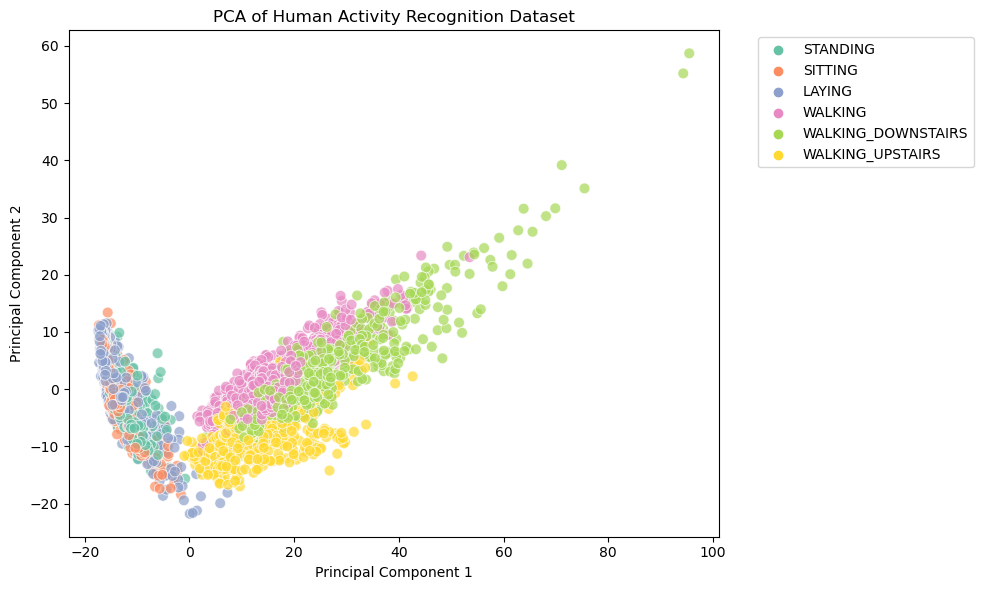

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# estandarizar para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)  # reduce to 2 components for visualization
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train['Activity'], palette='Set2', s=60, alpha=0.7)
plt.title('PCA Human Activity Recognition Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#vemos q podemos separar principalmente en mov o no mov

In [ ]:
# podría aplicar un kmeans a los datos reducidos, pero por el sobrelape que tienen con los 2 componentes, y porque no quiero utilizar ~60 componentes, no creo que sea útil xd

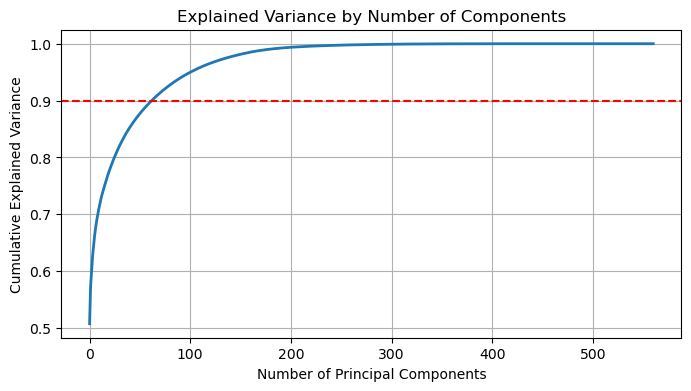

In [45]:
pca_100 = PCA().fit(X_scaled)
explained = pca_100.explained_variance_ratio_.cumsum()
plt.figure(figsize=(8, 4))
plt.plot(explained, linewidth=2)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--')
plt.show()

C:\Users\marca\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


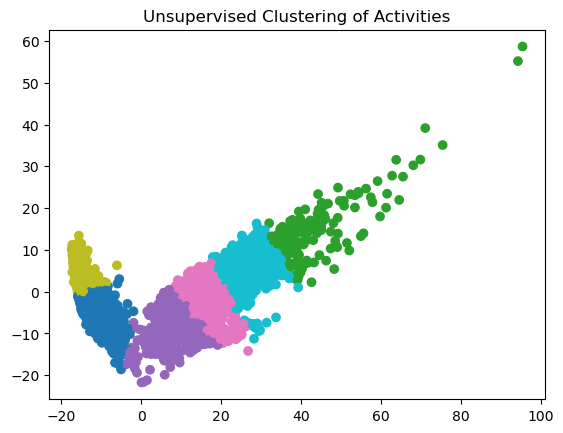

In [67]:
# hago el kmeans d todos modos pero solo confirmo que no sirve, se ve horrible
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(X_pca)

# Visualize
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10')
plt.title('Unsupervised Clustering of Activities')
plt.show()

In [ ]:
# Necesitamos así un chingo de componentes para poder explicar buena proporción de la varianza de los datos. so we need to upgrade this analysis !!

La precisión para profundidad = 1 es 0.35269095681750967
La precisión para profundidad = 2 es 0.6541043700088731
La precisión para profundidad = 3 es 0.8854719387755102
La precisión para profundidad = 4 es 0.8989378142561373
La precisión para profundidad = 5 es 0.9140354185152321
La precisión para profundidad = 6 es 0.9217897811298432
La precisión para profundidad = 7 es 0.9389296805678793
La precisión para profundidad = 8 es 0.9431462585034014
La precisión para profundidad = 9 es 0.9499482401656316
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.78      0.81      0.80       491
          STANDING       0.82      0.79      0.80       532
           WALKING       0.78      0.95      0.85       496
WALKING_DOWNSTAIRS       0.94      0.63      0.76       420
  WALKING_UPSTAIRS       0.76      0.80      0.78       471

          accuracy                           0.84      2947
         macr

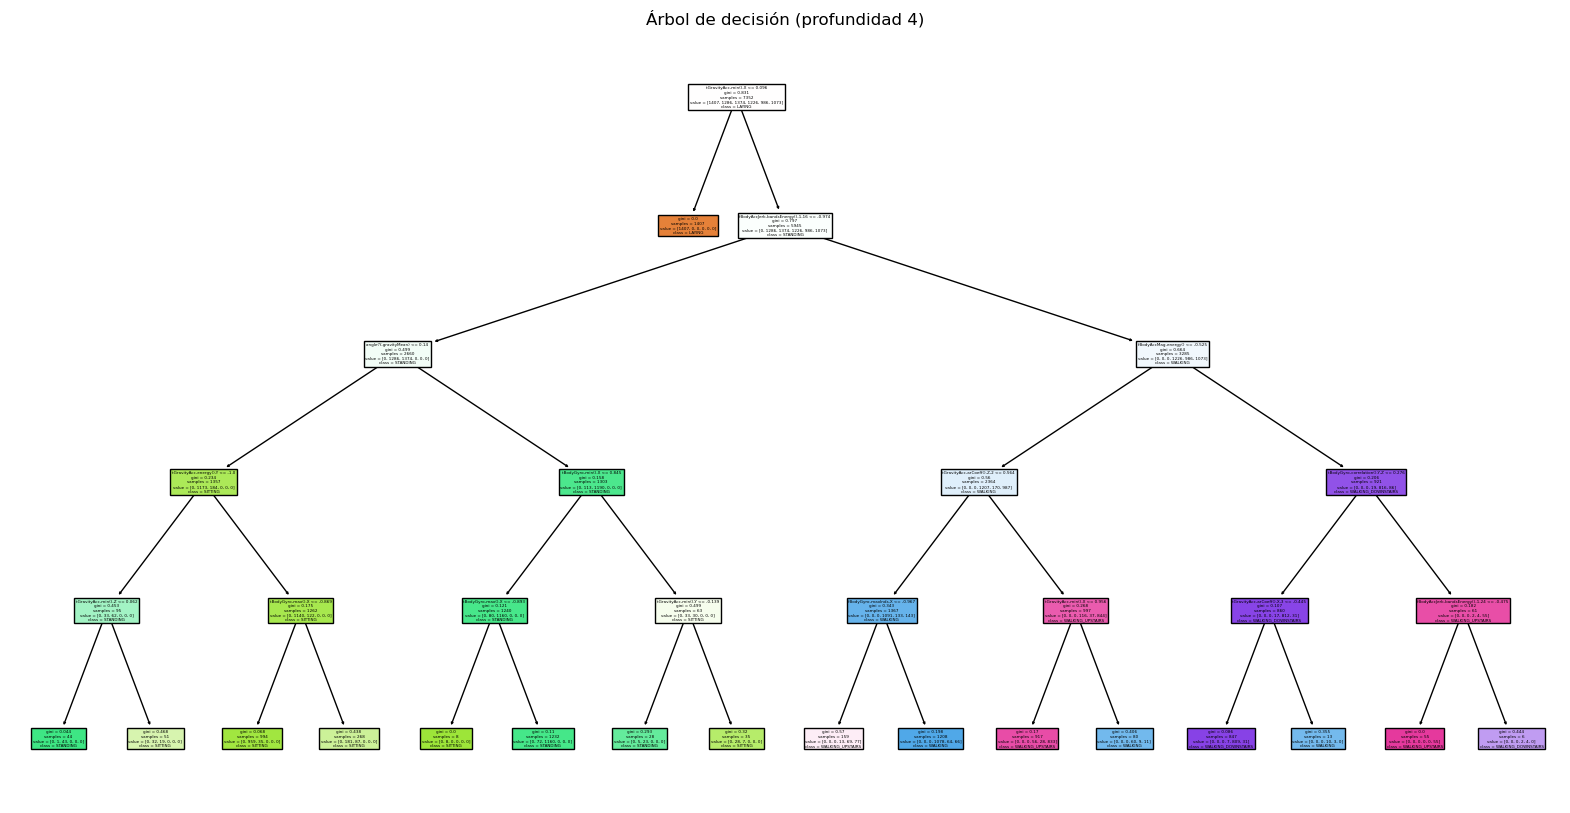

In [63]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

for i in range(1, 10):
    tree = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=i)
    tree.fit(X_train, y_train['Activity'])
    
    cv = KFold(n_splits=10, shuffle=True)
    scores = cross_val_score(tree, X_train, y_train, scoring="accuracy", cv=cv)
    score = np.mean(scores)
    print(f"La precisión para profundidad = {i} es {score}")

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train['Activity'])

# test
y_pred = tree.predict(X_test)
print(classification_report(y_test['Activity'], y_pred))

plot_tree(tree, feature_names=X_train.columns, class_names=tree.classes_, filled=True)
plt.title("Árbol de decisión (profundidad 5)")
plt.show()

In [69]:
clf = RandomForestClassifier(n_estimators=100, oob_score =True)
clf.fit(X_train, y_train.values.ravel())
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
clf.oob_score_

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.92      0.88      0.90       491
          STANDING       0.89      0.93      0.91       532
           WALKING       0.89      0.96      0.93       496
WALKING_DOWNSTAIRS       0.97      0.84      0.90       420
  WALKING_UPSTAIRS       0.89      0.92      0.90       471

          accuracy                           0.92      2947
         macro avg       0.93      0.92      0.92      2947
      weighted avg       0.93      0.92      0.92      2947



0.9800054406964092

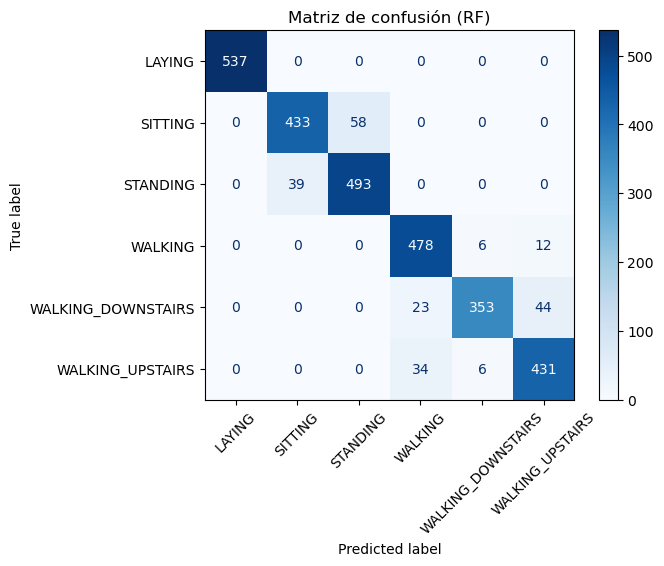

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test['Activity'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión (RF)")
plt.show()
#ya funciona bastante bien para este dataset pred

In [74]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# SVM con kernel RBF (no lineal)
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train['Activity'])

# Predicciones
y_svm_pred = svm.predict(X_test_scaled)

# Evaluación
print("SVM (RBF Kernel):\n")
print(classification_report(y_test['Activity'], y_svm_pred))

SVM (RBF Kernel):

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.94      0.90      0.92       491
          STANDING       0.92      0.95      0.93       532
           WALKING       0.96      0.97      0.97       496
WALKING_DOWNSTAIRS       0.98      0.92      0.95       420
  WALKING_UPSTAIRS       0.93      0.97      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



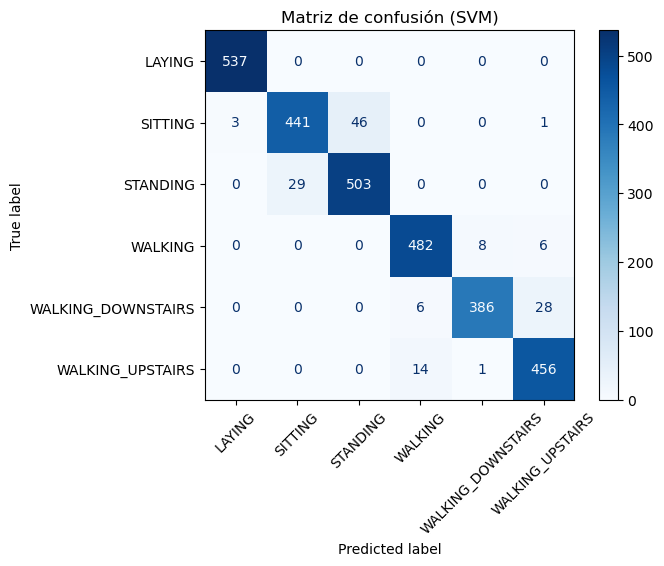

In [75]:
cm = confusion_matrix(y_test['Activity'], y_svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión (SVM)")
plt.show()
#funciona super bien, amamos

In [88]:
svm1 = SVC(C=5, kernel='rbf', random_state=42)
svm1.fit(X_train_scaled, y_train['Activity'])

y_pred1 = svm1.predict(X_test_scaled)

print(classification_report(y_test['Activity'], y_pred1))

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.95      0.97      0.96       496
WALKING_DOWNSTAIRS       0.97      0.92      0.94       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.95      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



In [90]:
svm2 = SVC(C=10, kernel='rbf', random_state=42)
svm2.fit(X_train_scaled, y_train['Activity'])

y_pred2 = svm2.predict(X_test_scaled)

print(classification_report(y_test['Activity'], y_pred2))

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.89      0.93       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.95      0.97      0.96       496
WALKING_DOWNSTAIRS       0.97      0.92      0.94       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.95      0.95      0.95      2947



In [82]:
best_svm = SVC(C=10, gamma=0.001, kernel='rbf', random_state=42)
best_svm.fit(X_train_scaled, y_train['Activity'])

y_best_pred = best_svm.predict(X_test_scaled)

print(classification_report(y_test['Activity'], y_best_pred))

Evaluación del mejor SVM en conjunto de prueba:

                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.96      0.88      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      0.98      0.97       496
WALKING_DOWNSTAIRS       0.98      0.93      0.95       420
  WALKING_UPSTAIRS       0.93      0.96      0.95       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947



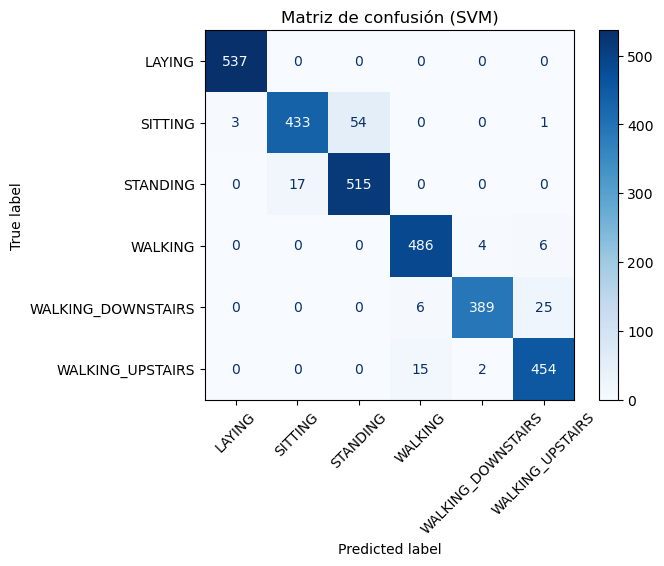

In [92]:
cm = confusion_matrix(y_test['Activity'], y_best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_svm.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión (SVM)")
plt.show()

In [ ]:
# modificar los hiperparámetros mejoró aún más el desempeño del modelo SVM. ya eran buenos, pero mejoraron todavía más. así que vale la pena :p